# Signal denoising using RNNs in PyTorch

In this post, I'll use PyTorch to create a simple Recurrent Neural Network (RNN) for denoising a signal. I started learning RNNs using PyTorch. However, I felt that many of the examples were fairly complex. So, here's an attempt to create a simple educational example.

### Problem description

Given a noisy sine wave as an input, we want to estimate the denoised signal. This is shown in the figure below.

![](denoising.png)

### Customary imports

In [1]:
import numpy as np
import math, random
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(0)

### Creating noisy and denoised signals

Let's now write functions to cerate a sine wave, add some noise on top of it. This way we're able to create a noisy verison of the sine wave.

In [2]:
# Generating a clean sine wave 
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq)

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out

Let's now invoke the functions we defined to generate the figure we saw in the problem description.

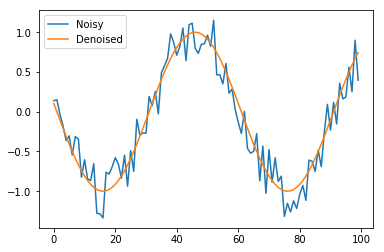

In [3]:
inp, out = sample(100)
plt.plot(inp, label='Noisy')
plt.plot(out, label ='Denoised')
plt.legend()

### Creating dataset

Now, let's write a simple function to generate a dataset of such noisy and denoised samples.

In [4]:
def create_dataset(n_samples=10000, sample_size=100):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out

Now, creating the dataset, and dividing it into train and test set.

In [5]:
data_inp, data_out = create_dataset()
train_inp, train_out = data_inp[:8000], data_out[:8000]
test_inp, test_out = data_inp[8000:], data_out[8000:]

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable

### Creating RNN

We have 1d sine waves, which we want to denoise. Thus, we have input dimension of 1. Let's create a simple 1-layer RNN with 30 hidden units. 

In [7]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [8]:
r

CustomRNN (
  (rnn): RNN(1, 30, batch_first=True)
  (linear): Linear (30 -> 1)
  (act): Tanh ()
)

### Training

In [9]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

0 0.5774930715560913
20 0.12028147280216217
40 0.11251863092184067
60 0.10834833979606628
80 0.11243857443332672
100 0.11533079296350479
120 0.09951132535934448
140 0.078636534512043
160 0.08674494177103043
180 0.07217984646558762
200 0.06266186386346817
220 0.05793667957186699
240 0.0723448321223259
260 0.05628745257854462
280 0.050240203738212585
300 0.06297950446605682


Great. As expected, the loss reduces over time.

### Generating prediction on test set

In [10]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)

In [11]:
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])

0.06105425953865051


### Visualising sample denoising

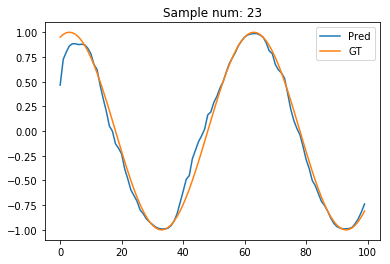

In [12]:
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

### Bidirectional RNN

Seems reasonably neat to me! If only the first few points were better esimtated. Any idea why they're not? Maybe, we need a bidirectional RNN? Let's try one, and I'll also add dropout to prevent overfitting.

In [13]:
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)
r

CustomRNN (
  (rnn): RNN(1, 30, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear (60 -> 1)
  (act): Tanh ()
)

In [14]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

0 0.6825199127197266
20 0.11104971915483475
40 0.07732641696929932
60 0.07210152596235275
80 0.06964801251888275
100 0.06717491149902344
120 0.06266810745000839
140 0.06302479654550552
160 0.05954732000827789
180 0.05402040109038353
200 0.05266999825835228
220 0.06145058199763298
240 0.0500367134809494
260 0.05388529226183891
280 0.053044941276311874
300 0.046826526522636414


In [15]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)

In [16]:
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])

0.050666142255067825


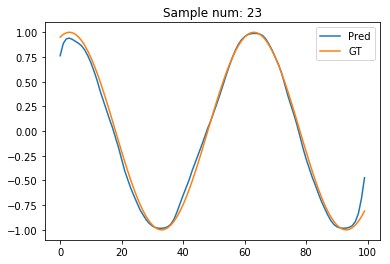

In [17]:
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

Hmm. The estimated signal looks better for the initial few points. But, gets worse for the final few points. Oops! Guess, now the reverse RNN causes problems for its first few points!

### From RNNs to GRU

Let's now replace our RNN with GRU to see if the model improves.

In [30]:
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)
r

CustomRNN (
  (rnn): GRU(1, 30, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear (60 -> 1)
  (act): Tanh ()
)

In [31]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(201):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

0 0.6294281482696533
20 0.11452394723892212
40 0.08548719435930252
60 0.07101015746593475
80 0.05964939296245575
100 0.053830236196517944
120 0.06312716007232666
140 0.04494623467326164
160 0.04309168830513954
180 0.04010637104511261
200 0.035212572664022446


In [32]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)

In [33]:
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])

0.03618593513965607


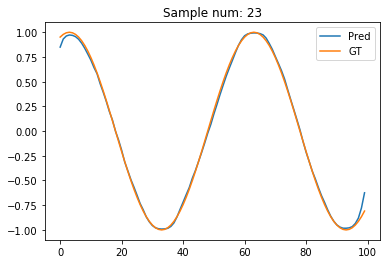

In [34]:
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

The GRU prediction seems to far better! Maybe, the RNNs suffer from the vanishing gradients problem?

### Visualising estimations as model improves

Let's now write a simple function to visualise the estimations as a function of iterations. We'd expect the estimations to improve over time.

In [37]:
plt.rcParams['animation.ffmpeg_path'] = './ffmpeg'
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(4, 3))
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(i):
    label = 'Iteration {0}'.format(i)
    ax.cla()
    ax.plot(np.array(predictions)[i, 0, :, 0].T, label='Pred')
    ax.plot(train_out[0, :], label='GT')
    ax.legend()
    ax.set_title(label)
 

anim = FuncAnimation(fig, update, frames=range(0, 201, 4), interval=20)
anim.save('learning.mp4',fps=20)
plt.close()

fig size: 72.0 DPI, size in inches [ 4.  3.]


In [38]:
from IPython.display import Video
Video("learning.mp4")

This looks great! We can see how our model learns to learn reasonably good denoised signals over time. It doesn't start great though. Would a better initialisation help? I certainly feel that for this particular problem it would, as predicting the output the same as input is a good starting point!

### Bonus: Handling missing values in denoised training data

The trick to handling missing values in the denoised training data (the quantity we wish to estimate) is to compute the loss only over the present values. This requires creating a mask for finding all entries except missing. 

One such way to do so would be: `mask = out > -1* 1e8` where `out` is the tensor containing missing values.

Let's first add some unknown values (`np.NaN`) in the training output data.

In [40]:
for num_unknown_values in range(50):
    train_out[np.random.choice(list(range(0, 8000))), np.random.choice(list(range(0, 100)))] = np.NAN

In [41]:
np.isnan(train_out).sum()

50

Testing using a network with few parameters.

In [42]:
r= CustomRNN(input_dim, 2, 1)
r

CustomRNN (
  (rnn): GRU(1, 30, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear (60 -> 1)
  (act): Tanh ()
)

In [43]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(20):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    # Create a mask to compute loss only on defined quantities
    mask = out > -1* 1e8
    loss = loss_func(pred[mask], out[mask])
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

0 0.6575785279273987


There you go! We've also learnt how to handle missing values!

I must thank Simon Wang and his helpful inputs on the [PyTorch discussion forum](https://discuss.pytorch.org/t/problem-with-vanilla-rnn/12235/12).